In [ ]:
from datasets import load_dataset,Dataset,load_from_disk,Image
from collections import defaultdict
import random
import os
import tqdm
import torch
from sae_lens.activation_visualization import load_llava_model,load_sae,generate_with_saev
# os.environ['HF_HOME'] ="/mnt/file2/changye/tmp/"
# os.environ['TMPDIR'] ="/mnt/file2/changye/tmp/"
# os.environ['HF_DATASETS_CACHE'] ="/mnt/file2/changye/tmp/"
# os.environ['https_proxy'] = "127.0.0.1:7895"



In [ ]:
# please replace these path to your own path
MODEL_NAME = "llava-hf/llava-v1.6-mistral-7b-hf"
model_path = "/aifs4su/yaodong/changye/model/llava-hf/llava-v1.6-mistral-7b-hf"
device = "cuda:5"
sae_device = "cuda:7"
sae_path = "/aifs4su/yaodong/changye/model/Antoinegg1/llavasae_obliec100k_SAEV"
dataset_path = "/aifs4su/yaodong/changye/data/Antoinegg1/Semantic_data/imagenet1k_10"
columns_to_read = ["input_ids", "pixel_values", "attention_mask", "image_sizes"]

save_path = "/aifs4su/yaodong/changye/data/Antoinegg1/Semantic_data/imagenet1k_10_test"


(
        processor,
        hook_language_model,
) = load_llava_model(MODEL_NAME, model_path, device,n_devices=2)

sae = load_sae(sae_path, sae_device)





In [ ]:
example_prompt = """You are provided with an image and a list of 10 possible labels. Your task is to classify the image by selecting the most appropriate label from the list below:

Labels:
0: "bonnet, poke bonnet"
1: "green mamba"
2: "langur"
3: "Doberman, Doberman pinscher"
4: "gyromitra"
5: "Saluki, gazelle hound"
6: "vacuum, vacuum cleaner"
7: "window screen"
8: "cocktail shaker"
9: "garden spider, Aranea diademata"

Carefully analyze the content of the image and identify which label best describes it. Then, output only the **corresponding number** from the list without any additional text or explanation.
"""
# 加载本地 JSON 数据

local_dataset = load_from_disk(dataset_path)
print(local_dataset)
# local_dataset = load_dataset("nlphuji/flickr30k", split="test",cache_dir="/aifs4su/yaodong/changye/data/flickr30k")
# sample_size = 1000
# local_dataset = local_dataset.shuffle(seed=42).select(range(sample_size))
print(local_dataset[1])


In [ ]:
def prepare_mc_input(sample, processor):
    """
    为图文选择任务（如 VQA 多选题）准备输入。
    
    每个样本包含字段：
      - "image": PIL 图像
      - "question": 问题字符串
      - "choices": 候选答案列表（如 ['one', 'ten', 'nine', 'thirty']）

    模型将根据图像内容和问题，从候选项中选出最合适的答案，并输出对应的编号（如 '1', '2', '3', '4'），只包含一个 token。
    """

    image = sample["image"]
    question = sample["question"]
    choices = sample["choices"]

    # 处理图像
    if not isinstance(image, Image.Image):
        image = Image.open(image["path"]) if isinstance(image, dict) else Image.fromarray(image)
    image = image.convert("RGB").resize((336, 336))

    # 构造选项字符串
    choice_list = "\n".join([f"{i + 1}. {c}" for i, c in enumerate(choices)])

    # 构造 prompt
    prompt = (
        f"<image>\nQuestion: {question}\n"
        f"Options:\n{choice_list}\n"
        "Answer with the number of the correct option only. Do not include any other text.\n"
        "Answer:"
    )

    # Tokenize prompt 和预处理图像
    text_inputs = processor.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    image_inputs = processor.image_processor(images=image, return_tensors="pt")

    return {
        "input_ids": text_inputs["input_ids"],
        "attention_mask": text_inputs["attention_mask"],
        "pixel_values": image_inputs["pixel_values"],
        "image_sizes": image_inputs["image_sizes"]
    }


In [ ]:
print(local_dataset)
print(local_dataset['image'][0])

In [99]:
from PIL import Image
system_prompt= " "
user_prompt= 'USER: \n<image> {input}'
assistant_prompt= '\nASSISTANT: {output}'
def prepare_inputs(prompt,image,processor):
    image = image.resize((336, 336)).convert('RGBA')
    formatted_prompt = f'{system_prompt}{user_prompt.format(input=prompt)}{assistant_prompt.format(output="")}'
    text_input = processor.tokenizer(formatted_prompt, return_tensors="pt")
    image_input = processor.image_processor(images=image, return_tensors="pt")
    # print(inputs)
    """处理样本并准备输入"""
    return {
        "input_ids": text_input["input_ids"],
        "attention_mask": text_input["attention_mask"],
        "pixel_values": image_input["pixel_values"],
        "image_sizes": image_input["image_sizes"],
    }

input_list= []
image_path="/mnt/file2/changye/SAELens-V-result/result/semantic_image/mustimi.png"
# image=Image.open(local_dataset[0]['image'])
idx=370
inputs=prepare_inputs(example_prompt,local_dataset[idx]['image'],processor)

# for data in tqdm.tqdm(local_dataset):
#     inputs=prepare_inputs(example_prompt,local_dataset["image"],processor)
# #     inputs = prepare_mc_input(data,processor )
#     input_list.append(inputs)
print(inputs["input_ids"].shape)
input_list.append(inputs)

torch.Size([1, 202])


In [100]:
# 定义文件路径
cosi_file_path = "/aifs4su/yaodong/changye/data/AA_preference_mistral-7b_interp/AA_preference_cosi_weight/cosi_feature_list.txt"  # 将此替换为你的文件路径

# 读取文件并转换为字典
osi_list = []
with open(cosi_file_path, "r") as file:
    for line in file:
        key, value = line.strip().split(",")  # 按逗号分割每行
        
        osi_list.append((int(key), float(value)))

# 输出结果
print(osi_list)

[(8, 0.1803319673417412), (27, 0.07624877010851419), (30, 0.16079967690265198), (37, 0.2320393756287136), (41, 0.1296554306894705), (77, 0.12057411458845058), (99, 0.16689908665348924), (104, 0.10100131130325447), (166, 0.13831489037555803), (180, 0.187928346047327), (202, 0.10203617812351685), (203, 0.17962658552532634), (219, 0.16600072836307597), (228, 0.12182254640492976), (240, 0.1280655098561415), (248, 0.23130211120002053), (314, 0.16100498079438566), (333, 0.15887215552555173), (340, 0.22784604186650345), (342, 0.177867149395456), (354, 0.18433397573445312), (365, 0.14000439074037976), (366, 0.2260172921269944), (392, 0.163625917906823), (395, 0.10237602041570819), (397, 0.23354237145256695), (404, 0.13226195000342453), (414, 0.18576910052133258), (422, 0.13475143882115018), (423, 0.20623218389319564), (429, 0.19252640342150534), (451, 0.21772166621892555), (489, 0.13929760982780956), (536, 0.21348896084067076), (572, 0.17933064329183576), (576, 0.1358896746449612), (583, 0.168

In [101]:
# print(input_list[0])
save_path = "/aifs4su/yaodong/changye/data/Antoinegg1/Semantic_data/imagenet1k_10_test"
input={
            "input_ids": input_list[0]["input_ids"].to(device),
            "attention_mask": input_list[0]["attention_mask"].to(device),
            "pixel_values": input_list[0]["pixel_values"].to(device),
            "image_sizes": input_list[0]["image_sizes"].to(device),
        }
total_activation_l0_norms_list,patch_indices_list,feature_acts_list=generate_with_saev(
                input, hook_language_model, processor, save_path, local_dataset["image"][idx], sae, sae_device,max_new_tokens=1,selected_feature_indices=osi_list, strategy="all",
            )

100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


In [102]:
print(feature_acts_list[0].shape)
print(patch_indices_list[0])
# target_text = 'Doberman'
# target_ids = processor.tokenizer.encode(target_text, add_special_tokens=False)
# print(target_ids)
# for i,token in enumerate(input["input_ids"][0]):
#     if token==2378:
#         print(i)
print(input["input_ids"][0].__len__())
text_start = patch_indices_list[0][-1] + 1

# decode_text = processor.tokenizer.decode(input["input_ids"][0], skip_special_tokens=False)
# print(input["input_ids"][0])
result1 = [i for i, val in enumerate(feature_acts_list[0][0][1258]) if val != 0]
result2 = [i for i, val in enumerate(feature_acts_list[0][0][1259]) if val != 0]
result3 = [i for i, val in enumerate(feature_acts_list[0][0][1260]) if val != 0]
image_set=set()
import tqdm
import numpy as np

image_set = set()
for idx in tqdm.tqdm(patch_indices_list[0]):
    # 获取非零索引（假设 feature_acts_list 包含 PyTorch 张量）
    nonzero_indices = torch.nonzero(feature_acts_list[0][0][idx]).flatten()
    
    # 转换为 Python 整数并更新集合
    image_set.update(nonzero_indices.cpu().numpy().astype(int).tolist())
# result1 = [(i, val) for i, val in enumerate(feature_acts_list[0][0][1258]) if val != 0]
# result2 = [(i, val) for i, val in enumerate(feature_acts_list[0][0][1259]) if val != 0]
# result3 = [(i, val) for i, val in enumerate(feature_acts_list[0][0][1260]) if val != 0]
intersection = set(result1) & set(result2) & set(result3) & image_set
print(list(intersection))
# print(image_set)

torch.Size([1, 1377, 65536])
[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 2

100%|██████████| 1152/1152 [00:00<00:00, 7599.74it/s]

[28680, 25232, 17297, 18322, 16161, 37806, 28210, 41142, 36932, 33481, 14668, 35920, 15312, 13916, 32607, 23392, 64613, 63096, 44031]


In [105]:
print(feature_acts_list[0][0][1260][44031])

tensor(3.0777)


In [106]:
{23392, 16161, 36932, 64613, 28680, 33481, 14668, 37806, 35920, 17297, 18322, 28210, 15312, 8793, 24060, 44031}
act_44031=set()
for idx in tqdm.tqdm(patch_indices_list[0]):
    # 获取非零索引（假设 feature_acts_list 包含 PyTorch 张量）
    if feature_acts_list[0][0][idx][44031]!=0:
        if idx>582:
           act_44031.update({idx-583})
        else:
           act_44031.update({idx})
print(act_44031)


100%|██████████| 1152/1152 [00:00<00:00, 138376.72it/s]

{514, 515, 4, 8, 525, 14, 527, 16, 530, 19, 21, 534, 535, 536, 537, 538, 22, 541, 542, 544, 550, 38, 552, 553, 551, 43, 556, 557, 558, 559, 560, 49, 561, 51, 562, 563, 564, 565, 566, 567, 50, 54, 572, 573, 574, 575, 576, 577, 578, 579, 68, 69, 70, 580, 581, 582, 74, 583, 586, 587, 589, 591, 592, 82, 595, 597, 86, 87, 90, 92, 93, 96, 97, 98, 101, 115, 118, 127, 140, 141, 142, 143, 144, 146, 149, 150, 151, 162, 164, 166, 168, 169, 170, 171, 174, 177, 187, 190, 193, 194, 199, 210, 211, 212, 214, 215, 216, 217, 222, 223, 225, 230, 46, 233, 234, 235, 236, 241, 243, 244, 245, 246, 247, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 261, 262, 264, 265, 266, 268, 269, 270, 271, 272, 274, 275, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 290, 292, 293, 294, 295, 296, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 311, 312, 314, 317, 318, 320, 324, 325, 326, 327, 328, 331, 332, 333, 336, 337, 338, 343, 345, 347, 348, 350, 352, 353, 357, 358, 361, 362, 363, 364, 365

In [97]:
print(idx)

1182


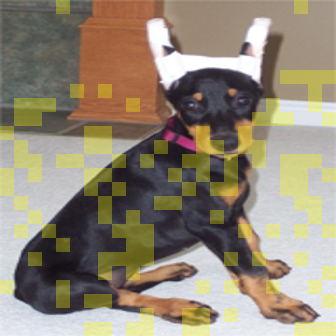

In [113]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

H, W = 336, 336
patch_count = 24
patch_size = H // patch_count  # 14

# 加载原始图像
img = np.array(local_dataset["image"][370].resize((H, W)))

# 如果是灰度图，转为RGB
if img.ndim == 2:
    img = np.stack([img] * 3, axis=-1)

# 创建半透明高亮层（黄色，透明度0.3）
highlight = np.zeros_like(img, dtype=np.float32)
highlight[..., 0] = 255  # R
highlight[..., 1] = 255  # G
highlight[..., 2] = 0    # B
alpha = 0.3  # 透明度

# 遍历所有patch
for i in range(patch_count):
    for j in range(patch_count):
        # 计算当前patch的全局索引
        patch_idx = i * patch_count + j
        
        # 如果这个patch在act_44031集合中
        if patch_idx in act_44031 and (feature_acts_list[0][0][patch_idx][44031]>5 or feature_acts_list[0][0][patch_idx+583][44031]>5 ):
            # 获取patch的像素区域
            patch_area = img[i*patch_size:(i+1)*patch_size, 
                            j*patch_size:(j+1)*patch_size]
            
            # 应用高亮效果：原始图像和高亮层混合
            img[i*patch_size:(i+1)*patch_size, 
                j*patch_size:(j+1)*patch_size] = (
                patch_area * (1 - alpha) + highlight[i*patch_size:(i+1)*patch_size, 
                                                  j*patch_size:(j+1)*patch_size] * alpha
            ).astype(np.uint8)

# 转换为PIL图像并更新
new_image = Image.fromarray(img.astype(np.uint8))
display(new_image)
# # 如果需要显示
# plt.imshow(new_image)
# plt.show()

In [ ]:

# output_list = []
activate_list=[]
patch_induce_list=[]
# image_list = []
with tqdm.tqdm(total=len(input_list)) as pbar:
    for inputs,data in zip(input_list,local_dataset):
        inputs={
            "input_ids": inputs["input_ids"].to(device),
            "attention_mask": inputs["attention_mask"].to(device),
            "pixel_values": inputs["pixel_values"].to(device),
            "image_sizes": inputs["image_sizes"].to(device),
        }
        total_activation_l0_norms_list,patch_indices_list=generate_with_saev(
                inputs, hook_language_model, processor, save_path, data["image"], sae, sae_device,max_new_tokens=1,selected_feature_indices=osi_list, strategy="all",
            )
        # print( total_activation_l1_norms_list[0].shape)
        # output_list.append(output[-1])
        # image_list.append({"image":data["image"].resize((336, 336)),"label":data["label"],"activation_l0":total_activation_l0_norms_list[0]})
        activate_list.append(total_activation_l0_norms_list[0])
        patch_induce_list.append(patch_indices_list)
        pbar.update(1)

   

In [ ]:
assert len(activate_list) == len(local_dataset), "数量不一致，请检查"
assert len(patch_induce_list) == len(local_dataset), "数量不一致，请检查"

# 3. 通过 map 将新列添加进来
def add_new_columns(example, idx):
    return {
        "activate_list": activate_list[idx],
        "patch_induce_list": patch_induce_list[idx]
    }

local_dataset = local_dataset.map(add_new_columns, with_indices=True)

# 4. 查看是否添加成功
print(local_dataset)
# local_dataset[0]  # 查看单条的数据


local_dataset.save_to_disk(save_path)

In [ ]:
print(image_list[0].keys())

In [ ]:
from datasets import Dataset, Features, Array3D, Array2D,ClassLabel, Value
import numpy as np
import datasets
raw_data = []
for idx, entry in enumerate(image_list):
    # 转为 numpy 数组
    img_array = np.array(entry['image'])
    label = entry['label']
    activation = np.array(entry['activation_l0'], dtype=np.float32)

    # 检查image的维度和类型，期望 (336, 336, 3)
    if img_array.ndim == 2:
    # 若是灰度图，扩展成3通道
        if img_array.shape == (336, 336):
            img_array = np.stack([img_array]*3, axis=-1)
        else:
            raise ValueError(f"Image at index {idx} has unexpected shape {img_array.shape}")
    elif img_array.shape == (336, 336, 4):
        # 如果图像是 RGBA 格式，裁剪掉 alpha 通道，变成 RGB
        img_array = img_array[..., :3]

    # 再次检查image形状
    if img_array.shape != (336, 336, 3):
        raise ValueError(f"Image at index {idx} has shape {img_array.shape}, expected (336, 336, 3)")
    if img_array.dtype != np.uint8:
        # 若不是uint8，则尝试转换
        img_array = img_array.astype(np.uint8)

    # 检查activation的维度和类型，期望(24, 24)
    if activation.ndim == 1:
        # 若是(24*24,)的1D数组，重塑为(24,24)
        if activation.size == 24*24:
            activation = activation.reshape((24, 24))
        else:
            raise ValueError(f"Activation at index {idx} has size {activation.size}, cannot reshape to (24,24)")
    elif activation.shape != (24, 24):
        raise ValueError(f"Activation at index {idx} has shape {activation.shape}, expected (24,24)")

    # 确保类型为float32
    if activation.dtype != np.float32:
        activation = activation.astype(np.float32)

    raw_data.append({"image": img_array, "label": label, "activation_l0": activation})

# 转换为字典格式
raw_data_dict = {
    "image": [entry["image"] for entry in raw_data],
    "label": [entry["label"] for entry in raw_data],
    "activation_cosi": [entry['activation_l0'] for entry in raw_data]  # 可以直接是numpy数组
}

# 构建 ClassLabel 的 names 列表
label_names = sorted(list(set(raw_data_dict["label"])))  # 排序以保证稳定性

# 定义数据特征
features = Features({
    "image": datasets.Image(),    # 图像的维度和类型
    "label": ClassLabel(names=label_names),                  # 标签分类
    "activation_cosi": Array2D(dtype="float32", shape=(24, 24))   # 激活值的维度和类型
})

# 创建 Hugging Face 数据集
raw_hf_dataset = Dataset.from_dict(raw_data_dict, features=features)

# 验证数据集结构
print(raw_hf_dataset)

raw_hf_dataset.save_to_disk("imagenet10_activated_cosi_dataset")

In [ ]:
total=1000
acc=0
for i,output in enumerate(output_list):
    if output == str(local_dataset[i]['label']):
        acc+=1
print(acc)
print(f"accuracy:{acc/total}")

In [ ]:
# print(type(output_list[0]))
# print(local_dataset[0]['label'])
# print(len(image_list))
print(image_list[0]['activation'].shape)

In [ ]:

from PIL import Image
import numpy as np
from datasets import load_from_disk, Dataset, Features, ClassLabel as DsImage
import datasets
# data = load_from_disk("/mnt/file2/changye/dataset/semantic_data/imagenet10_cosi_mask75_dataset")
data=load_from_disk("/aifs4su/yaodong/changye/data/flickr3k_cosi")
print(data)
patch_induce_list=data[0]["patch_induce_list"][0]
print(patch_induce_list)
image_act=data[0]["activate_list"]
selected_acts = [image_act[i] for i in patch_induce_list]

selected_acts = np.array(selected_acts)  # 长度为1152

assert len(selected_acts) == 1152, "selected_acts 长度不是 1152"
folded_acts = np.array(selected_acts[:576] + selected_acts[576:]) / 2  # 长度为576

print(folded_acts.shape)  # (576,)



In [ ]:
#我现在有一张336*336的图片，和一个576大小的激活map，这个map按顺序地对应到图片上的每个patch(14X14),我希望能够按照激活值筛patch，例如将激活值后50%的patch改变为黑色，生成一张新的图片，请补全以下代码
threshold_percentile = 25  # 激活值的百分位数阈值
mask_image_list = []

for item in image_list:
    img = item['image']
    activation_mask = item['folded_acts']
    
    # 将PIL Image转换为numpy数组
    if isinstance(img, Image.Image):
        img = np.array(img)
    
    # 如果图像是灰度图（2D），转为三通道
    if img.ndim == 2:
        img = np.stack([img] * 3, axis=-1)  # 转为RGB格式
    
    # 对于576大小的激活mask，对应24x24个patch
    patch_count = 24
    patch_size = 336 // patch_count
    activation_mask = np.array(activation_mask).reshape(patch_count, patch_count)
    
    # 使用np.percentile计算指定百分位数作为阈值
    threshold = np.percentile(activation_mask, threshold_percentile)
    
    # 遍历每个patch并根据激活值进行操作
    for i in range(patch_count):
        for j in range(patch_count):
            if activation_mask[i, j] <= threshold:
                # 将对应patch区域设为黑色
                img[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :] = 0

    # 将修改后的图像加入列表
    mask_image_list.append({"image":Image.fromarray(img),"label":item['label']})
    

# 假设 mask_image_list 已经按照你提供的格式存在
# mask_image_list.append({"image": Image.fromarray(img), "label": item['label']})

# 将 PIL 图片转换为 numpy 数组，并格式化数据
data = []
for entry in mask_image_list:
    img_array = np.array(entry['image'])  # 转换为 numpy 数组
    label = entry['label']               # 获取标签
    data.append({"image": img_array, "label": label})

# 转换为字典格式
data_dict = {
    "image": [entry["image"] for entry in data],
    "label": [entry["label"] for entry in data]
}

# 定义数据特征（包括 image 和 label）
features = Features({
    "image": datasets.Image(),  # 图像的维度和类型
    "label": ClassLabel(names=list(set(data_dict["label"])))  # 标签分类
})

# 创建 Hugging Face 数据集
hf_dataset = Dataset.from_dict(data_dict, features=features)

# 验证数据集结构
print(hf_dataset)
hf_dataset.save_to_disk(f"imagenet10_cosi_mask{100-threshold_percentile}_dataset")


In [ ]:
display(mask_image_list[0]['image'])

In [ ]:
from PIL import Image
import numpy as np
from datasets import load_from_disk, Dataset, Features, ClassLabel as DsImage
import datasets
data = load_from_disk("/mnt/file2/changye/dataset/imagenet1k_10")

def sample_patches(example, keep_ratio):
    """对图像进行14x14的patch分割并随机保留一定比例的patch，其余用0填充。"""
    image = example["image"]
    if not isinstance(image, Image.Image):
        image = Image.fromarray(np.uint8(image))
    image = image.resize((336,336)).convert('RGB')  # 确保为RGB三通道

    image = np.array(image)  # (H, W, C)
    h, w, c = image.shape
    patch_size = 14
    # 假设图像尺寸可以被14整除，如不能，则需预处理
    num_patches_h = h // patch_size
    num_patches_w = w // patch_size
    total_patches = num_patches_h * num_patches_w

    keep_count = int(total_patches * keep_ratio)
    keep_indices = set(np.random.choice(total_patches, keep_count, replace=False))

    new_image = image.copy()
    patch_index = 0
    for i in range(num_patches_h):
        for j in range(num_patches_w):
            if patch_index not in keep_indices:
                # 将该patch区域填充为黑色
                new_image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :] = 0
            patch_index += 1
    
    # 转回PIL Image
    new_image = Image.fromarray(new_image.astype(np.uint8))
    return new_image

keep_ratio = 0.75  # 例如：保留25%的patch，从而丢弃75%
new_images = []
new_labels = []  # 假设原数据集有 'label' 字段，如有其它字段也同样处理

for i in range(len(data)):
    example = data[i]
    transformed_image = sample_patches(example, keep_ratio=keep_ratio)
    # 转成numpy array，以便后续使用Image特征类型
    transformed_array = np.array(transformed_image)
    new_images.append(transformed_array)
    # 假设有 'label' 字段，如果没有可去掉
    new_labels.append(example["label"])

# 构建新的数据集
# 假设原数据集有一个label字段且为ClassLabel类型，否则根据实际情况调整
features = Features({
    "image": datasets.Image(),
    "label": data.features["label"]  # 如果label是ClassLabel之类的特征，则直接引用即可
})

new_dataset = Dataset.from_dict({"image": new_images, "label": new_labels}, features=features)

# 保存新数据集
new_dataset.save_to_disk("/mnt/file2/changye/dataset/imagenet10_random_mask75_dataset")


In [ ]:

from PIL import Image
import numpy as np
from datasets import load_from_disk, Dataset, Features, ClassLabel as DsImage
import datasets

# 加载数据
# data = load_from_disk("/mnt/file2/changye/dataset/semantic_data/imagenet10_cosi_mask75_dataset")
data = load_from_disk("/aifs4su/yaodong/changye/data/OKVQA_cosi_Vmasked_0.25")

# =========================
# 为每条样本构造统一格式的 prompt（不进行 mask）
# =========================

def build_prompt(sample):
    question = sample["question"]
    choices = sample["choices"]

    # 构造 choice 列表
    choice_list_text = "\n".join([f"{i+1}. {c}" for i, c in enumerate(choices)])

    # 拼接完整 prompt
    prompt = (
        f"<image>\nQuestion: {question}\n"
        f"Options:\n{choice_list_text}\n"
        "Answer with the number of the correct option only. Do not include any other text.\n"
        "Answer:"
    )

    return {"prompt": prompt}

# 添加 prompt 字段
data_with_prompt = data.map(build_prompt, desc="Building prompts (no mask)", num_proc=4)

# 保存处理后的数据集
save_path = "/aifs4su/yaodong/changye/data/OKVQA_cosi_Vmasked_0.25_p"
data_with_prompt.save_to_disk(save_path)

print(f"✅ Prompt 已构建并保存至：{save_path}")



In [ ]:
from PIL import Image
import numpy as np
from datasets import load_from_disk, Dataset, Features, ClassLabel as DsImage
import datasets
data=load_from_disk("/aifs4su/yaodong/changye/data/Antoinegg1/Semantic_data/imagenet1k_10")
print(data)
idx=212
# print(data[idx]['prompt'])
# print(data[idx]['correct_choice_idx'])
display(data[idx]['image'])

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取 global_fail_counts.txt (CSV 格式)
df = pd.read_csv("/aifs4su/yaodong/changye/data/semantic_result/global_fail_counts.txt")

# 提取 fail_count 列
fail_counts = df["fail_count"]
fail_counts.append
# 绘制直方图
plt.hist(fail_counts, bins=range(fail_counts.max() + 2), edgecolor="black")
plt.title("Distribution of Fail Count")
plt.xlabel("Fail Count")
plt.ylabel("Number of Samples")

# 显示图像
plt.show()
